In [3]:
import pandas as pd
import re
import gensim
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

def tokenize_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function

    Args:
        df = data frame object to apply cleaning to

    Returns:
        pandas data frame with cleaned tokens
    """

    df['tokens'] = df.text.apply(preprocess_tweet)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [4]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"./twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)






[0.00760987 0.1458119  0.8465781 ]


In [21]:
def get_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores


In [36]:
df =pd.read_csv('1mo_tweet.csv',index_col=0)


In [37]:
df.drop('polarity',axis= 1,inplace=True)

In [38]:
df.timestamp = pd.to_datetime(df.timestamp)

In [39]:
df['date'] = df.timestamp.apply(lambda time_s:  time_s.date)

In [40]:
df = tokenize_tweets(df)

Complete. Number of Tweets that have been cleaned and tokenized : 38087


In [41]:
appiled_df = df.apply(lambda row: get_sentiment(row.tokens), axis='columns', result_type='expand')
df = pd.concat([df, appiled_df], axis='columns')


In [120]:
df2 = df.rename({df2.columns[8]: 'Negative', df2.columns[9]: 'Netural',df2.columns[10]: 'Positive'}, axis='columns')  # new method
df

,user,timestamp,replies,likes,retweets,text,date,tokens,0,1,2
2374189,coinstats,2018-01-01 00:00:01+00:00,0.0,0.0,0.0,"bitcoin - btc\nprice: $13,941.10\nchange in 1h...",2018-01-01,bitcoin btc price change market cap rank,0.091979,0.863309,0.044712
2374190,xp_jpy,2018-01-01 00:00:01+00:00,0.0,11.0,6.0,2018年01月01日 10:00\n[doge建]\n1xp=0.1561554円\n24...,2018-01-01,年月日 doge建 時間の最高値 時間の最安値 btc建 時間の最高値 時間の最安値 時価総...,0.172065,0.794435,0.033499
2374188,asens_inc,2018-01-01 00:00:02+00:00,0.0,1.0,1.0,"01/01 10:00現在\n\n#bitcoin : 1,662,700円↓\n#nem ...",2018-01-01,,0.258294,0.451272,0.290433
2374187,BitcoinCash_ES,2018-01-01 00:00:03+00:00,0.0,0.0,0.0,"cotización del bitcoin cash: 2,046 10.€ | -0.7...",2018-01-01,cotización del bitcoin cash kraken,0.047913,0.877334,0.074753
2374186,crypto_paraguay,2018-01-01 00:00:03+00:00,0.0,0.0,0.0,cotizaciones al 31/12/2017 10:00 pm\nbitcoin (...,2018-01-01,cotizaciones bitcoin btc ethereum eth litecoin...,0.032696,0.895348,0.071956
...,...,...,...,...,...,...,...,...,...,...,...
9638308,ResultDrivenPR,2018-01-31 23:51:19+00:00,2.0,0.0,1.0,one of the best ico’s coming up for so many re...,2018-01-31,best ico come reason judge,0.076694,0.826908,0.096398
16805435,AllColorsTV,2018-01-31 23:53:51+00:00,3.0,2.0,2.0,"viberate is listing profiles of over 150,000 a...",2018-01-31,viberate list profile artists book agencies ve...,0.052302,0.875694,0.072004
2408552,coin_sight,2018-01-31 23:56:44+00:00,4.0,0.0,0.0,#btc average: 10220.91$\n\n#bitfinex - 10221.0...,2018-01-31,average,0.259744,0.534707,0.205548
2408528,coin_sight,2018-01-31 23:56:44+00:00,3.0,0.0,0.0,#cryptos: \n\n#btc 10232.40$ | 8243.62€\n#xrp ...,2018-01-31,,0.258294,0.451272,0.290433


In [71]:
import seaborn as sns
df2

,user,timestamp,replies,likes,retweets,text,date,tokens,Negative,Netural,Positive
2374189,coinstats,2018-01-01 00:00:01+00:00,0.0,0.0,0.0,"bitcoin - btc\nprice: $13,941.10\nchange in 1h...",2018-01-01,bitcoin btc price change market cap rank,0.091979,0.863309,0.044712
2374190,xp_jpy,2018-01-01 00:00:01+00:00,0.0,11.0,6.0,2018年01月01日 10:00\n[doge建]\n1xp=0.1561554円\n24...,2018-01-01,年月日 doge建 時間の最高値 時間の最安値 btc建 時間の最高値 時間の最安値 時価総...,0.172065,0.794435,0.033499
2374188,asens_inc,2018-01-01 00:00:02+00:00,0.0,1.0,1.0,"01/01 10:00現在\n\n#bitcoin : 1,662,700円↓\n#nem ...",2018-01-01,,0.258294,0.451272,0.290433
2374187,BitcoinCash_ES,2018-01-01 00:00:03+00:00,0.0,0.0,0.0,"cotización del bitcoin cash: 2,046 10.€ | -0.7...",2018-01-01,cotización del bitcoin cash kraken,0.047913,0.877334,0.074753
2374186,crypto_paraguay,2018-01-01 00:00:03+00:00,0.0,0.0,0.0,cotizaciones al 31/12/2017 10:00 pm\nbitcoin (...,2018-01-01,cotizaciones bitcoin btc ethereum eth litecoin...,0.032696,0.895348,0.071956
...,...,...,...,...,...,...,...,...,...,...,...
9638308,ResultDrivenPR,2018-01-31 23:51:19+00:00,2.0,0.0,1.0,one of the best ico’s coming up for so many re...,2018-01-31,best ico come reason judge,0.076694,0.826908,0.096398
16805435,AllColorsTV,2018-01-31 23:53:51+00:00,3.0,2.0,2.0,"viberate is listing profiles of over 150,000 a...",2018-01-31,viberate list profile artists book agencies ve...,0.052302,0.875694,0.072004
2408552,coin_sight,2018-01-31 23:56:44+00:00,4.0,0.0,0.0,#btc average: 10220.91$\n\n#bitfinex - 10221.0...,2018-01-31,average,0.259744,0.534707,0.205548
2408528,coin_sight,2018-01-31 23:56:44+00:00,3.0,0.0,0.0,#cryptos: \n\n#btc 10232.40$ | 8243.62€\n#xrp ...,2018-01-31,,0.258294,0.451272,0.290433


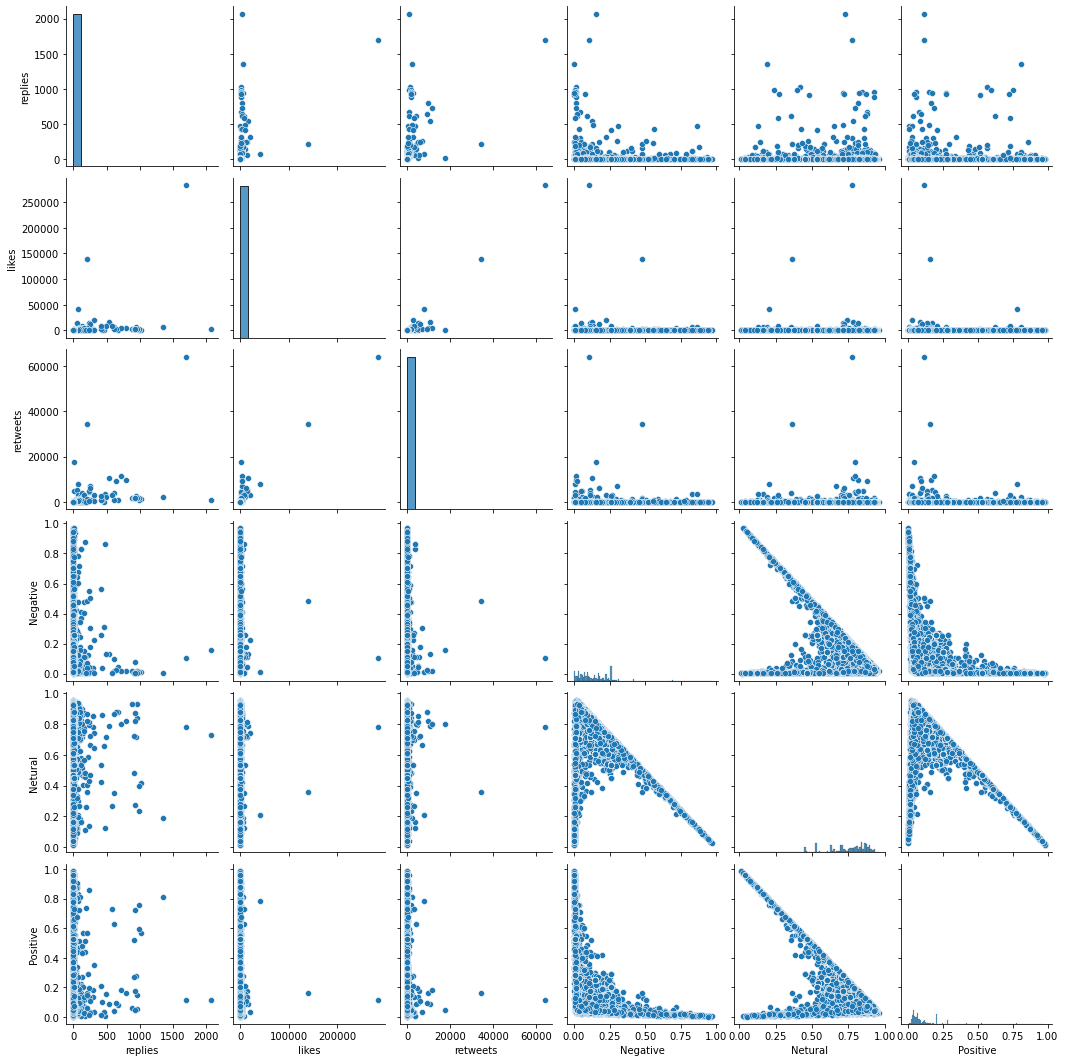

In [72]:
sns.pairplot(df2)

In [73]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38087 entries, 2374189 to 2408502
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   user       38087 non-null  object             
 1   timestamp  38087 non-null  datetime64[ns, UTC]
 2   replies    38087 non-null  float64            
 3   likes      38087 non-null  float64            
 4   retweets   38087 non-null  float64            
 5   text       38087 non-null  object             
 6   date       38087 non-null  object             
 7   tokens     38087 non-null  object             
 8   Negative   38087 non-null  float32            
 9   Netural    38087 non-null  float32            
 10  Positive   38087 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(3), float64(3), object(4)
memory usage: 3.1+ MB


In [118]:
tweet_mean = df2.groupby('date').mean()

In [103]:
tweet_mean = pd.concat([tweet_mean, btc_data.Close], axis=1)

In [82]:
btc_data = pd.read_csv("BTC-USD.csv")

In [117]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],[{"type": "scatter"}]]
)

fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=btc_data.Close,
        mode="lines",
        name="BTC Close"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=tweet_mean.Positive,
        mode="markers",
        marker=dict(color='green'),

        name="Positive Sentiment"

    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=tweet_mean.Netural,
        mode="markers",
        marker=dict(color='orange'),

        name="Netural Sentiment"

    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=tweet_mean.Negative,
        mode="markers",
        marker=dict(color='red'),

        name="Negative Sentiment"

    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=tweet_mean.replies,
        mode="lines",

        name="Replies"

    ),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=tweet_mean.likes,
        mode="lines",

        name="Likes"

    ),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(
        x=btc_data.Date,
        y=tweet_mean.retweets,
        mode="lines",

        name="Retweets"

    ),
    row=3, col=1
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="BTC Close price and tweets mean sentiment",
    
)

fig.show()


In [97]:
covariance = np.cov(btc_data.Close, tweet_mean.Negative)
print(covariance)

[[4.53067080e+06 4.83893525e+00]
 [4.83893525e+00 8.14910907e-05]]


In [98]:
from scipy.stats import spearmanr
corr, _ = spearmanr(btc_data.Close, tweet_mean.Negative)
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.253


In [101]:
from scipy.stats import pearsonr
corr, _ = pearsonr(btc_data.Close,tweet_mean.Negative)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.252


In [126]:
covariance = np.cov(btc_data.Close, tweet_mean.Positive)
print(covariance)

[[ 4.53067080e+06 -4.24696050e+00]
 [-4.24696050e+00  4.83705575e-05]]


In [125]:
from scipy.stats import spearmanr
corr, _ = spearmanr(btc_data.Close, tweet_mean.Positive)
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.240


In [124]:
from scipy.stats import pearsonr
corr, _ = pearsonr(btc_data.Close,tweet_mean.Positive)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.287


In [129]:
covariance = np.cov(btc_data.Close, tweet_mean.Netural)
print(covariance)

[[ 4.53067080e+06 -5.91969053e-01]
 [-5.91969053e-01  5.49586284e-05]]


In [130]:
from scipy.stats import spearmanr
corr, _ = spearmanr(btc_data.Close, tweet_mean.Netural)
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.027


In [131]:
from scipy.stats import pearsonr
corr, _ = pearsonr(btc_data.Close,tweet_mean.Netural)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.038
